In [1]:
try:
    from googlesearch import search
except ImportError:
    print("No module named 'google' found")
 
# to search
query = "adidas"
 
for j in search(query, tld="co.in", num=10, stop=10, pause=2):
    print(j)

https://www.adidas.com/us
https://www.adidas-group.com/
http://www.adidas-group.com/
https://commons.wikimedia.org/wiki/File:Adidas_Logo.svg
https://en.wikipedia.org/wiki/Adidas
https://www.instagram.com/adidas/?hl=en
https://www.instagram.com/adidasoriginals/?hl=en
https://twitter.com/adidas?lang=en
https://apps.apple.com/us/app/adidas/id1266591536
https://www.facebook.com/adidas/


In [ ]:
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd

(755, 1024, 3)


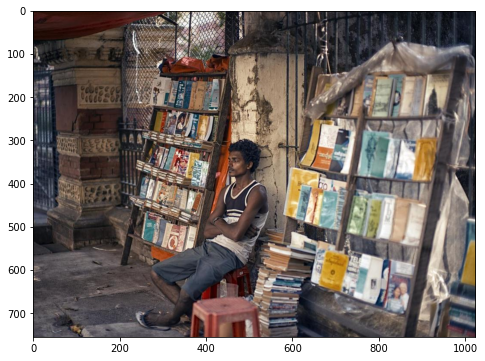

In [ ]:
img = cv2.imread('/content/drive/MyDrive/testrpn/person.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
original_img_height, original_img_width, _ = img.shape
plt.figure(figsize=(9, 6))
plt.imshow(img)

[[234.0, 297.0, 553.0, 745.0]]


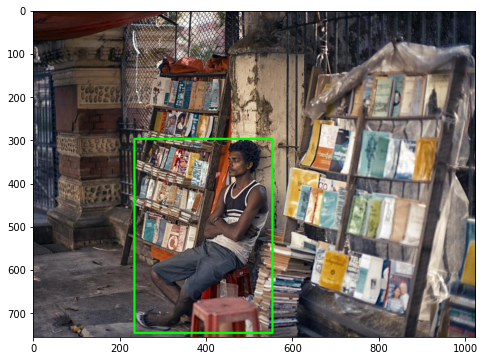

In [ ]:
#распарсил файл с аннотацией и отрисовал ограничивающую рамку
tree = ET.parse('/content/drive/MyDrive/testrpn/person.xml')
root = tree.getroot()
all_coord_list = []
for boxes in root.iter('object'):
  ymin = float(boxes.find("bndbox/ymin").text)
  xmin = float(boxes.find("bndbox/xmin").text)
  ymax = float(boxes.find("bndbox/ymax").text)
  xmax = float(boxes.find("bndbox/xmax").text)
coord_list = [xmin, ymin, xmax, ymax]
all_coord_list.append(coord_list)
print(all_coord_list[:1])
img_copy = np.copy(img)
plt.figure(figsize=(9, 6))
for i, bbox in enumerate(all_coord_list):
  cv2.rectangle(img_copy, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color=(0, 255, 0), thickness=3) 
plt.imshow(img_copy)
plt.show() 


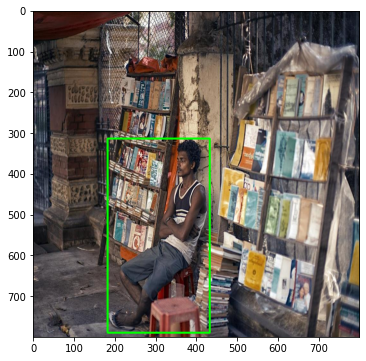

In [ ]:
#на вход надо будет подавать изображения фиксированного размера
#можно будет настроить нужный размер и также пересчитаю координаты рамок в зависимости от размера 
required_img_height  = 800
required_img_width = 800
img = cv2.resize(img, dsize=(required_img_height, required_img_width), interpolation=cv2.INTER_CUBIC)

dx = required_img_width/original_img_width
dy = required_img_height/original_img_height 
img_copy = np.copy(img)
plt.figure(figsize=(9, 6))
for i, bbox in enumerate(all_coord_list):
  bbox[0] = bbox[0] * dx
  bbox[1] = bbox[1] * dy
  bbox[2] = bbox[2] * dx
  bbox[3] = bbox[3] * dy
  cv2.rectangle(img_copy, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color=(0, 255, 0), thickness=3) 
plt.imshow(img_copy)
plt.show() 

x stride 16
y stride 16
центры точек по x [  8  24  40  56  72  88 104 120 136 152 168 184 200 216 232 248 264 280
 296 312 328 344 360 376 392 408 424 440 456 472 488 504 520 536 552 568
 584 600 616 632 648 664 680 696 712 728 744 760 776 792]
центры точек по y [  8  24  40  56  72  88 104 120 136 152 168 184 200 216 232 248 264 280
 296 312 328 344 360 376 392 408 424 440 456 472 488 504 520 536 552 568
 584 600 616 632 648 664 680 696 712 728 744 760 776 792]
[[8, 8], [8, 24], [8, 40], [8, 56], [8, 72], [8, 88], [8, 104], [8, 120], [8, 136], [8, 152]]


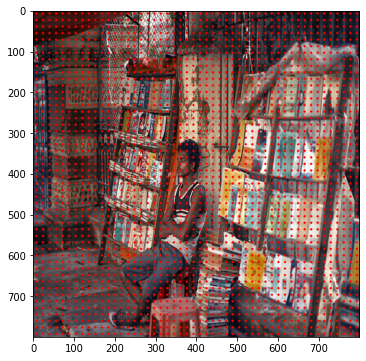

In [ ]:
#чтобы было видно построю на изображении тоже и anchors
#тут задам размер карты признаков которая будет на выходе из сверточной сети и которая на вход rpn пойдет
feature_map_width = 50
feature_map_height = 50
#с каким шагом будут точки располагаться в зависимости от размера карты признаков
x_stride = int(required_img_width / feature_map_width)
y_stride = int(required_img_height / feature_map_width)
print('x stride',x_stride)
print('y stride',y_stride)
# arange равномерно распределит значения центров якорных точек в указанном интервале с укаханным шагом
x_center = np.arange(8, required_img_width, x_stride) 
y_center = np.arange(8, required_img_width, y_stride)
print('центры точек по x',x_center)
print('центры точек по y',y_center)

#сделаю список из координат [[x1,y1],[x1,y2]...]
anchors_coord_list = []
for i,x in enumerate(x_center):
  for j,y in enumerate(y_center):
    coord=[x,y]
    anchors_coord_list.append(coord)
print(anchors_coord_list[:10])

img_copy = np.copy(img)
plt.figure(figsize=(9, 6))
for i, coord in enumerate(anchors_coord_list):
  cv2.circle(img_copy, (int(coord[0]), int(coord[1])), radius=1, color=(255, 0, 0), thickness=3) 
plt.imshow(img_copy)
plt.show()




22500


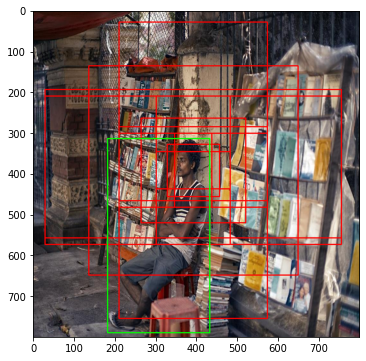

In [ ]:
#для каждой якорной точки теперь нужно построить по 9 anchorbox
#all_anchor_boxes лист с anchor boxes заданные через центр якорной точки и ширину и высоту
all_anchor_boxes = []
anchor_ratio_list = [0.5, 1, 2] 
anchor_scale_list = [8, 16, 32] 

anchors_count = len(anchors_coord_list) * len(anchor_ratio_list) * len(anchor_scale_list)

#n_object = len(bbox_list)

#лист с anchor boxes заданные через координаты углов 
#anchor_boxes_list = np.zeros(shape= (anchors_count, 4))
#print(anchor_boxes_list)
anchor_boxes_list = []

#count = 0
for center in anchors_coord_list:
  center_x, center_y = center[0], center[1]
  for ratio in anchor_ratio_list:
    for scale in anchor_scale_list:
      anchor_box_height = pow(pow(scale, 2)/ ratio, 0.5)
      anchor_box_width = anchor_box_height * ratio
      anchor_box_height *= x_stride
      anchor_box_width *= y_stride

      anchor_xmin = center_x - 0.5 * anchor_box_width
      anchor_ymin = center_y - 0.5 * anchor_box_height
      anchor_xmax = center_x + 0.5 * anchor_box_width
      anchor_ymax = center_y + 0.5 * anchor_box_height
      all_anchor_boxes.append([center_x, center_y, anchor_box_width, anchor_box_height])
      anchor_box = [anchor_xmin, anchor_ymin, anchor_xmax, anchor_ymax]
      anchor_boxes_list.append(anchor_box)
      #anchor_boxes_list[count] = [anchor_xmin, anchor_ymin, anchor_xmax, anchor_ymax]
      #count += 1
          
img_copy = np.copy(img)
plt.figure(figsize=(9, 6))
print(len(anchor_boxes_list))
#c 11014 по 11025 просто для примера,а иначе просто все изображение в сетку и не понятно как отрисовались для 1 точки
for i,anchor_box in enumerate(anchor_boxes_list[11014: 11025]): 
  cv2.rectangle(img_copy, (int(anchor_box[0]), int(anchor_box[1])), (int(anchor_box[2]), int(anchor_box[3])), color=(255, 0, 0), thickness=2) 

#исходная ограничивающая рамка
for i, bbox in enumerate(all_coord_list):
  cv2.rectangle(img_copy, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color=(0, 255, 0), thickness=2)
    
plt.imshow(img_copy)
plt.show()

Исходное количество anchor_boxes  22500
anchor_boxes внутри изображения  18100


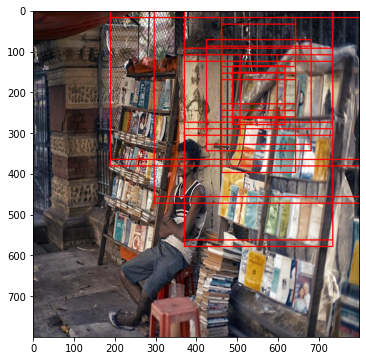

In [ ]:
#выделим anchor_boxes внутри изображения
inside_anchor_list=[]
inside_anchor_box_id =[]
for i,anchor_box in enumerate(anchor_boxes_list):
  if(int(anchor_box[0]) >= 0 & int(anchor_box[1]) >= 0 & int(anchor_box[2]) <= required_img_width & int(anchor_box[3])<= required_img_height ):
    inside_anchor_list.append(anchor_box)
    inside_anchor_box_id.append(i)

#print(inside_anchor_idx_list.shape)
print('Исходное количество anchor_boxes ',len(anchor_boxes_list))
print('anchor_boxes внутри изображения ',len(inside_anchor_list))
img_copy = np.copy(img)
plt.figure(figsize=(9, 6))
#где то ошибся и все равно рамки выходят за изображение.Нужно будет поправить
for i,anchor_box in enumerate(inside_anchor_list[11005: 11025]): 
  cv2.rectangle(img_copy, (int(anchor_box[0]), int(anchor_box[1])), (int(anchor_box[2]), int(anchor_box[3])), color=(255, 0, 0), thickness=2) 
plt.imshow(img_copy)
plt.show()

In [ ]:
#взял готовую реализацию,но суть понятна
def IOU(box1, box2):
    """
    Compute overlap (IOU) between box1 and box2
    """
    
    # ------calculate coordinate of overlapping region------
    # take max of x1 and y1 out of both boxes
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    
    # take min of x2 and y2 out of both boxes
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # check if they atleast overlap a little
    if (x1 < x2 and y1 < y2):
        # ------area of overlapping region------
        width_overlap = (x2 - x1)
        height_overlap = (y2 - y1)
        area_overlap = width_overlap * height_overlap
    else:
        # there is no overlap
        return 0
    
    # ------computing union------
    # sum of area of both the boxes - area_overlap
    
    # height and width of both boxes
    width_box1 = (box1[2] - box1[0])
    height_box1 = (box1[3] - box1[1])
    
    width_box2 = (box2[2] - box2[0])
    height_box2 = (box2[3] - box2[1])
    
    # area of box1 and box2
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    
    # union (including 2 * overlap area (double count))
    area_union_overlap = area_box1 + area_box2
    
    # union
    area_union = area_union_overlap - area_overlap
    
    # compute IOU
    iou = area_overlap/ area_union
    
    return iou

[[0.       ]
 [0.       ]
 [0.       ]
 ...
 [0.       ]
 [0.       ]
 [0.0009717]]
       anchor_id  object_0_iou   max_iou  best_orig_box
0           1350      0.000000  0.000000              0
1           1359      0.000000  0.000000              0
2           1368      0.000000  0.000000              0
3           1377      0.000000  0.000000              0
4           1386      0.000000  0.000000              0
...          ...           ...       ...            ...
18095      22495      0.000000  0.000000              0
18096      22496      0.000000  0.000000              0
18097      22497      0.000000  0.000000              0
18098      22498      0.000000  0.000000              0
18099      22499      0.000972  0.000972              0

[18100 rows x 4 columns]
Лучший IOUs для каждого объекта на изображении: [0.5539597]
Номер лучшего anchor box: [3799]
Anchor boxes c таким же IOU: [3799 3807 3815 3823 3831 3839 3847 4199 4207 4215 4223 4231 4239 4247
 4599 4607 4615 4623 4631

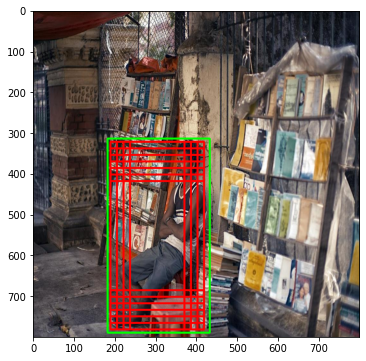

In [ ]:
inside_anchor_count = len(inside_anchor_box_id)
#количество объектов на исходном изображении
objects_count = len(all_coord_list)
iou_list = np.zeros((inside_anchor_count, objects_count))
for orig_box_id, orig_box in enumerate(all_coord_list):
  for anchor_box_id, anchor_box in enumerate(inside_anchor_list):
    #iou_result = [anchor_box_id,orig_box_id,IOU(orig_box, anchor_box)]
    iou_list[anchor_box_id][orig_box_id] = IOU(orig_box, anchor_box)
print(iou_list)
#print(inside_anchor_count)
data = {"anchor_id" :inside_anchor_box_id}
data.update({f"object_{idx}_iou":iou_list[:, idx] for idx in range(objects_count)})
data["max_iou"] = iou_list.max(axis= 1)
data["best_orig_box"] = iou_list.argmax(axis= 1)

df_iou = pd.DataFrame(data)
print(df_iou)

best_ious = df_iou.drop(["anchor_id", "max_iou", "best_orig_box"],axis= 1).max().values
print(f"Лучший IOUs для каждого объекта на изображении: {best_ious}")
best_anchors = df_iou.drop(["anchor_id", "max_iou", "best_orig_box"],axis= 1).values.argmax(axis= 0)
print(f"Номер лучшего anchor box: {best_anchors}")
#anchor boxes с таким же IOU как и у самого лучшего
top_anchors = np.where(iou_list == best_ious)[0]
print(f"Anchor boxes c таким же IOU: {top_anchors}")

img_copy= np.copy(img)
plt.figure(figsize=(9, 6))
for i in top_anchors:
  cv2.rectangle(img_copy, (int(inside_anchor_list[i][0]), int(inside_anchor_list[i][1])), (int(inside_anchor_list[i][2]), int(inside_anchor_list[i][3])), color=(255, 0, 0), thickness=3) 

for i, bbox in enumerate(all_coord_list):
  cv2.rectangle(img_copy, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color=(0, 255, 0), thickness=3)

plt.imshow(img_copy)
plt.show()